<a href="https://colab.research.google.com/github/AndSiq97/Cats-vs.-Dogs-Image-Classification/blob/main/Dogs_vs_Cats_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import cv2 as cv
import os
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import IPython.display as display
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Dense, Lambda, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from PIL import Image
import torch
import io
from glob import glob

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"dewman7","key":"de015a0128b48abaf66f96aa63d02ba5"}'}

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
  Using cached kaggle-1.5.6-py3-none-any.whl


In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Load Data

In [ ]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# import shutil
# shutil.rmtree('/content')

In [ ]:
#unzipping the zip files and deleting the zip files (Run this cell TWO times)
!unzip \*.zip # && rm *.zi

Streaming output truncated to the last 5000 lines.
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           
  inflating: test1/5520.jpg          
  inflating: test1/5521.jpg          

Images and Labels 

In [ ]:
# def load_images_from_folder(folder):
#   images = []
#   for filename in os.listdir(folder):
#     img = cv.imread(os.path.join(folder,filename))
#     if img is not None:
#       images.append(img)
#   return images


def filepaths_of_images_from_folder(folder):
  filepath_of_images = []
  for root, dirs, files in os.walk(folder):
    for filename in files:
        # rel_dir = os.path.relpath(dir_, folder)
        # rel_file = os.path.join(rel_dir, filename)
        if(filename.endswith(".jpg")):
          filepath_of_images.append(os.path.join(root, filename))

  return filepath_of_images

def filenames_of_images_from_folder(folder):
  filename_of_images = []
  filepath_of_images = filepaths_of_images_from_folder(folder)
  for filepath in filepath_of_images:
    filename_of_images.append(os.path.basename(filepath))
 
  return filename_of_images

In [ ]:
#@title
# training_images = load_images_from_folder("/content/train")
# testing_images = load_images_from_folder("/content/test1")

In [ ]:
training_filepaths = filepaths_of_images_from_folder("/content/train")
training_filenames = filenames_of_images_from_folder("/content/train")

testing_filepaths = filepaths_of_images_from_folder("/content/test1")
testing_filenames = filenames_of_images_from_folder("/content/test1")

In [ ]:
print("Number of training filepaths are: ", len(training_filepaths))
print("Number of training filenames are: ", len(training_filenames))
print("Number of training images are: ", len(next(os.walk('/content/train'))[2]))
print("          ")
print("Number of testing filepaths are: ", len(testing_filepaths))
print("Number of testing filenames are: ", len(testing_filenames))
print("Number of testing images are: ", len(next(os.walk('/content/test1'))[2]))

Number of training filepaths are:  25000
Number of training filenames are:  25000
Number of training images are:  25000
          
Number of testing filepaths are:  12500
Number of testing filenames are:  12500
Number of testing images are:  12500


In [ ]:
train_test_df = pd.DataFrame({'File Path':training_filepaths,'File Name':training_filenames})
train_test_df.head()

,File Path,File Name
0,/content/train/dog.5777.jpg,dog.5777.jpg
1,/content/train/cat.9991.jpg,cat.9991.jpg
2,/content/train/cat.10594.jpg,cat.10594.jpg
3,/content/train/cat.791.jpg,cat.791.jpg
4,/content/train/cat.3833.jpg,cat.3833.jpg


In [ ]:
train_test_df.tail()

,File Path,File Name
24995,/content/train/cat.5497.jpg,cat.5497.jpg
24996,/content/train/dog.2456.jpg,dog.2456.jpg
24997,/content/train/cat.6639.jpg,cat.6639.jpg
24998,/content/train/dog.1491.jpg,dog.1491.jpg
24999,/content/train/dog.3689.jpg,dog.3689.jpg


In [ ]:
train_test_df.loc[train_test_df['File Name'].str.contains('dog'), 'File Name'] = 'dog'
train_test_df.loc[train_test_df['File Name'].str.contains('cat'), 'File Name'] = 'cat'
train_test_df.rename(columns = {'File Name' : 'Label'}, inplace = True)
train_test_df.rename(columns = {'File Path' : 'File Path of Image'}, inplace = True)
# train_test_df = pd.concat([train_test_df, pd.DataFrame(training_images)], axis = 1)
# train_test_df.rename(columns = {0 : 'Image Numpy Array'}, inplace = True)
train_test_df = pd.concat([train_test_df, pd.DataFrame(training_filenames)], axis = 1)
train_test_df.rename(columns = {0 : 'File Name of Image'}, inplace = True)
train_test_df.head()

,File Path of Image,Label,File Name of Image
0,/content/train/dog.5777.jpg,dog,dog.5777.jpg
1,/content/train/cat.9991.jpg,cat,cat.9991.jpg
2,/content/train/cat.10594.jpg,cat,cat.10594.jpg
3,/content/train/cat.791.jpg,cat,cat.791.jpg
4,/content/train/cat.3833.jpg,cat,cat.3833.jpg


In [ ]:
train_test_df.shape

(25000, 3)

In [ ]:
np.array(list(set(train_test_df['Label'])))

array(['cat', 'dog'], dtype='<U3')

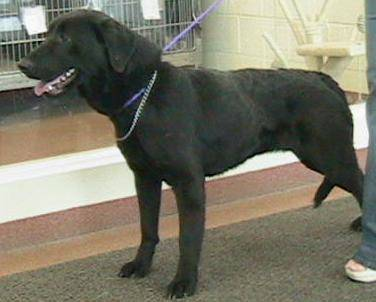

The label of this image is:  dog
             


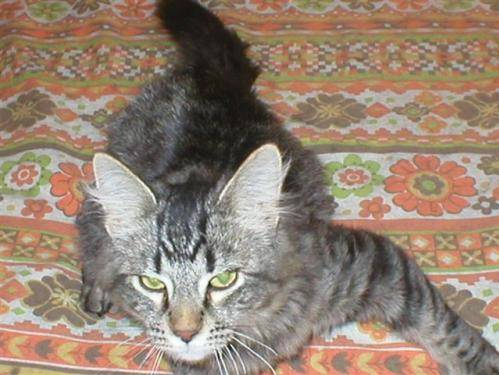

The label of this image is:  cat


In [ ]:
# Displaying Image of Dog and Cat in train_test_df
cv2_imshow(cv.imread(train_test_df['File Path of Image'].iloc[0]))
print('The label of this image is: ', train_test_df['Label'].iloc[0])
print("             ")
cv2_imshow(cv.imread(train_test_df['File Path of Image'].iloc[2]))
print('The label of this image is: ', train_test_df['Label'].iloc[2])

Transfer Learning to Classify Dog vs. Cat Images

In [ ]:
# Split train_test_df into train dataframe and test dataframe
train, val = train_test_split(train_test_df, test_size = 0.25, random_state = 42)

In [ ]:
print("Size of train dataframe is: ", train.shape)
train.index = np.arange(0, len(train))
train.head()

Size of train dataframe is:  (18750, 3)


,File Path of Image,Label,File Name of Image
0,/content/train/cat.3084.jpg,cat,cat.3084.jpg
1,/content/train/cat.9376.jpg,cat,cat.9376.jpg
2,/content/train/dog.3570.jpg,dog,dog.3570.jpg
3,/content/train/dog.10005.jpg,dog,dog.10005.jpg
4,/content/train/cat.388.jpg,cat,cat.388.jpg


In [ ]:
# Number of Images in train dataset
length_train = len(train.index)
length_train

18750

In [ ]:
print("Size of validation dataframe is: ", val.shape)
val.index = np.arange(0, len(val))
val.head()

Size of validation dataframe is:  (6250, 3)


,File Path of Image,Label,File Name of Image
0,/content/train/cat.2935.jpg,cat,cat.2935.jpg
1,/content/train/cat.10565.jpg,cat,cat.10565.jpg
2,/content/train/cat.11997.jpg,cat,cat.11997.jpg
3,/content/train/dog.7587.jpg,dog,dog.7587.jpg
4,/content/train/dog.7178.jpg,dog,dog.7178.jpg


In [ ]:
# Number of Images in val dataset
length_val = len(val.index)
length_val

6250

In [ ]:
!mkdir /content/cats_dogs_data

!mkdir /content/cats_dogs_data/train
!mkdir /content/cats_dogs_data/val

os.mkdir('/content/cats_dogs_data/train/dog')
os.mkdir('/content/cats_dogs_data/train/cat')
os.mkdir('/content/cats_dogs_data/val/dog')
os.mkdir('/content/cats_dogs_data/val/cat')

In [ ]:
train_dog_cat_class_dict = {}
train_dog_cat_class_dict['cat'] = 0
train_dog_cat_class_dict['dog'] = 0
print('train_dog_cat_class_dict: ')
print(train_dog_cat_class_dict)

train_dog_cat_class_dict: 
{'cat': 0, 'dog': 0}


In [ ]:
val_dog_cat_class_dict = {}
val_dog_cat_class_dict['cat'] = 0
val_dog_cat_class_dict['dog'] = 0
print('val_dog_cat_class_dict: ')
print(val_dog_cat_class_dict)

val_dog_cat_class_dict: 
{'cat': 0, 'dog': 0}


In [ ]:
# Remove entire folder and contents 
# import shutil
# shutil.rmtree('/content/cats_dogs_data/test_for_preds/')

In [ ]:
import PIL.Image as Image

for i in range(length_train):
  img = Image.fromarray(cv.imread(train['File Path of Image'].iloc[i]))
  path = "/content/cats_dogs_data/train/"
  train_dog_cat_class_dict[train['Label'][i]] += 1
  name_image = path + train['Label'][i] + '/' + train['File Name of Image'][i]
  img.save(name_image)

for i in range(length_val):
  img = Image.fromarray(cv.imread(val['File Path of Image'].iloc[i]))
  path = "/content/cats_dogs_data/val/"
  val_dog_cat_class_dict[val['Label'][i]] += 1
  name_image = path + val['Label'][i] + '/' + val['File Name of Image'][i]
  img.save(name_image)

Label for this image is:  cat


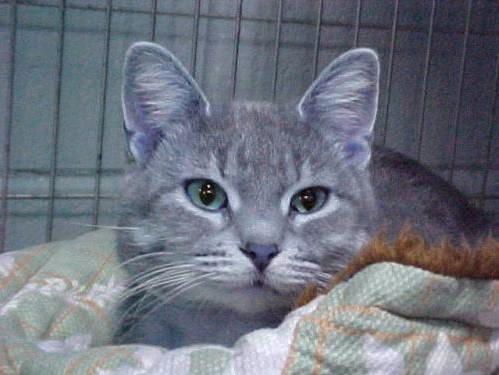

In [ ]:
# Show some random images from train folder
import random
path = "/content/cats_dogs_data/train"
random_folder_number = random.choice(os.listdir(path))
# print(random_folder_number)
label_path = path + "/" + str(random_folder_number) 
random_image_name = random.choice(os.listdir(label_path))
# print(random_image_name)
image_path = label_path + "/" + str(random_image_name)
print("Label for this image is: ", random_folder_number)
Image.open(image_path)

Label for this image is:  dog


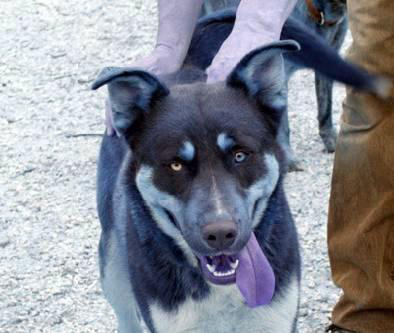

In [ ]:
# Show some random images from val folder
import random
path = "/content/cats_dogs_data/val"
random_folder_number = random.choice(os.listdir(path))
# print(random_folder_number)
label_path = path + "/" + str(random_folder_number) 
random_image_name = random.choice(os.listdir(label_path))
# print(random_image_name)
image_path = label_path + "/" + str(random_image_name)
print("Label for this image is: ", random_folder_number)
Image.open(image_path)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
# # from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import layers,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.models import Model
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [ ]:
train_path = '/content/cats_dogs_data/train'
valid_path = '/content/cats_dogs_data/val'

In [ ]:
# Number of files
from glob import glob
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [ ]:
# Number of images in train folder
len(image_files)

18750

In [ ]:
# Number of images in val folder
len(valid_image_files)

6250

In [ ]:
# Number of classes in train folder (there's two: cat and dog)
folders = glob(train_path + '/*')
len(folders)

2

In [ ]:
# Image size
# IMAGE_SIZE = [224, 224]

In [ ]:
train_data = ImageDataGenerator()
train_generator = train_data.flow_from_directory('/content/cats_dogs_data/train', target_size = (224,224))
val_data = ImageDataGenerator()
val_generator = val_data.flow_from_directory('/content/cats_dogs_data/val', target_size = (224,224))

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [ ]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
model = keras.Sequential([
      vgg,
      keras.layers.Flatten(),
      keras.layers.Dense(256, activation = 'relu'),
      keras.layers.Dense(256, activation = 'relu'),
      keras.layers.Dense(2, activation = 'softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_13 (Dense)            (None, 256)               6422784   
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dense_15 (Dense)            (None, 2)                 514       
                                                                 
Total params: 21,203,778
Trainable params: 6,489,090
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from keras import optimizers
# adam = tf.optimizers.Adam()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#@title
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255.,
#     # preprocessing_function=preprocess_input,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     # fill_mode='nearest'
#     )

In [ ]:
#@title
# test_datagen = ImageDataGenerator(
#     rescale=1.0/255.,
#     # preprocessing_function=preprocess_input,
#     # rotation_range=40,
#     # width_shift_range=0.2,
#     # height_shift_range=0.2,
#     # shear_range=0.2,
#     # zoom_range=0.2,
#     # horizontal_flip=True,
#     # fill_mode='nearest'
#     )

In [ ]:
#@title
# train_generator = train_datagen.flow_from_directory(train_path,
#                                                     target_size = (224, 224),
#                                                     batch_size = 32,
#                                                     class_mode = 'binary')

In [ ]:
#@title
# val_generator = test_datagen.flow_from_directory(valid_path,
#                                                  target_size = (224, 224),
#                                                  batch_size = 32,
#                                                  class_mode = 'binary')

In [ ]:
model_history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=100,
    validation_steps=25,
    )

Epoch 1/5
100/100 [==============================] - 740s 7s/step - loss: 0.1302 - accuracy: 0.9747 - val_loss: 0.1388 - val_accuracy: 0.9650
Epoch 2/5
100/100 [==============================] - 737s 7s/step - loss: 0.1129 - accuracy: 0.9791 - val_loss: 0.0772 - val_accuracy: 0.9750
Epoch 3/5
100/100 [==============================] - 737s 7s/step - loss: 0.1044 - accuracy: 0.9806 - val_loss: 0.1085 - val_accuracy: 0.9737
Epoch 4/5
100/100 [==============================] - 737s 7s/step - loss: 0.0705 - accuracy: 0.9819 - val_loss: 0.1059 - val_accuracy: 0.9812
Epoch 5/5
100/100 [==============================] - 737s 7s/step - loss: 0.0731 - accuracy: 0.9850 - val_loss: 0.1350 - val_accuracy: 0.9688


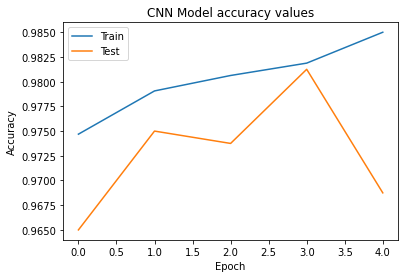

In [ ]:
# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Test dataframe for Predictions
df_for_predictions = pd.DataFrame({'File Path':testing_filepaths,'File Name':testing_filenames})
df_for_predictions = df_for_predictions.drop('File Name', 1)
df_for_predictions.rename(columns = {'File Path' : 'File Path of Image'}, inplace = True)
df_for_predictions["Label"] = ""
df_for_predictions.head()
df_for_predictions = pd.concat([df_for_predictions, pd.DataFrame(testing_images)], axis = 1)
df_for_predictions.rename(columns = {0 : 'Image Numpy Array'}, inplace = True)
df_for_predictions = pd.concat([df_for_predictions, pd.DataFrame(testing_filenames)], axis = 1)
df_for_predictions.rename(columns = {0 : 'File Name of Image'}, inplace = True)
df_for_predictions.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


,File Path of Image,Label,Image Numpy Array,File Name of Image
0,/content/test1/12242.jpg,,"[[[118, 121, 112], [121, 124, 115], [120, 123,...",12242.jpg
1,/content/test1/11314.jpg,,"[[[119, 167, 141], [126, 174, 148], [71, 122, ...",11314.jpg
2,/content/test1/1990.jpg,,"[[[15, 64, 78], [32, 81, 95], [46, 95, 109], [...",1990.jpg
3,/content/test1/6909.jpg,,"[[[188, 164, 188], [182, 158, 182], [178, 152,...",6909.jpg
4,/content/test1/10303.jpg,,"[[[67, 87, 104], [66, 86, 103], [65, 85, 102],...",10303.jpg


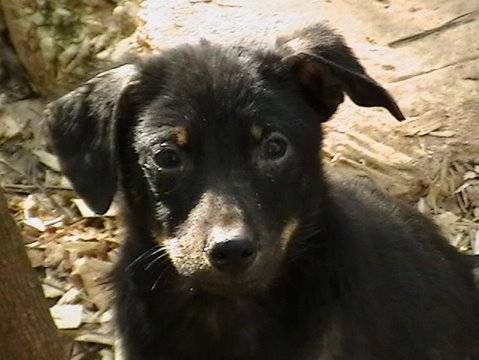

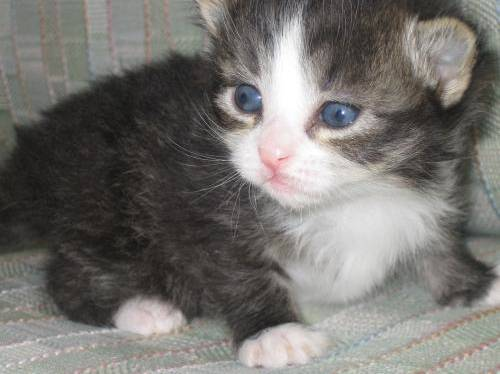

In [ ]:
# Displaying Image of Dog and Cat in df_for_predictions
cv2_imshow(df_for_predictions['Image Numpy Array'].iloc[2])
print("             ")
cv2_imshow(df_for_predictions['Image Numpy Array'].iloc[16])

In [ ]:
df_for_predictions.shape

(12500, 4)

In [ ]:
# Number of Images in df_for_predictions dataset
length_test = len(df_for_predictions.index)
length_test

12500

In [ ]:
os.mkdir('/content/cats_dogs_data/test_for_preds/')

for i in range(length_test):
  img = Image.fromarray(df_for_predictions['Image Numpy Array'][i])
  path = "/content/cats_dogs_data/test_for_preds/"
  name_image = path + df_for_predictions['File Name of Image'][i]
  img.save(name_image)

In [ ]:
# Predicting (Classifying) image 
def predict_label_of_image(image_path):
  img = cv.imread(image_path)
  img = cv.resize(img,(224,224))
  img = np.reshape(img,[1,224,224,3])

  class_names = ['cat', 'dog'] 
                
  classes = np.argmax(model.predict(img), axis = -1)

  # print(classes)

  names = [class_names[i] for i in classes]

  return names[0]

In [ ]:
# from tensorflow.keras.preprocessing import image
# # predicting label of chosen test image
# image_path = '/content/cats_dogs_data/test_for_preds/1.jpg'
# img = image.load_img(image_path, target_size=(224, 224))
# img_array = image.img_to_array(img)
# img_batch = np.expand_dims(img_array, axis=0)
# img_preprocessed = preprocess_input(img_batch)
# prediction = model.predict(img_preprocessed)
# prediction

Predicted Label for this image is:  dog


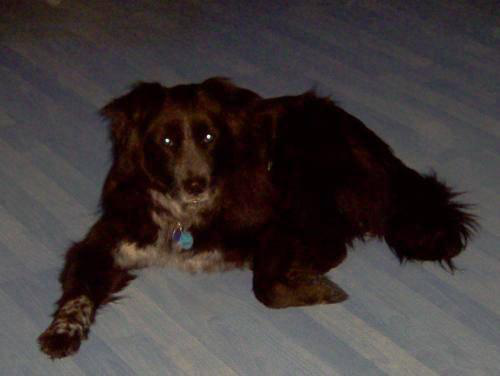

In [ ]:
# Show some random images and PREDICTIONS from test_for_preds folder
import random
path = "/content/cats_dogs_data/test_for_preds/"
random_image_name = random.choice(os.listdir(path))
# print(random_image_name)
image_path = path + "/" + str(random_image_name)

# check prediction for random chosen image
pred = predict_label_of_image(image_path)

print("Predicted Label for this image is: ", pred)
Image.open(image_path)

In [ ]:
#@title
# img_height,img_width=180,180
# batch_size=32
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   '/content/flowers_data/train',
#   validation_split=0.0,
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

In [ ]:
#@title
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   '/content/flowers_data/test',
#   validation_split=0.0,
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

In [ ]:
#@title
# resnet_model = Sequential()

# pretrained_model= tf.keras.applications.ResNet50(include_top=False,
#                    input_shape=(180,180,3),
#                    pooling='avg',classes=104,
#                    weights='imagenet')

# for layer in pretrained_model.layers:
#         layer.trainable=False

# resnet_model.add(pretrained_model)

In [ ]:
#@title
# resnet_model.add(Flatten())
# resnet_model.add(Dense(512, activation='relu'))
# resnet_model.add(Dense(104, activation='softmax'))

In [ ]:
#@title
# resnet_model.summary()

In [ ]:
#@title
# resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10)

In [ ]:
#@title
# fig1 = plt.gcf()
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.axis(ymin=0.4,ymax=1)
# plt.grid()
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.legend(['train', 'validation'])
# plt.show()

In [ ]:
#@title
# train_images_192 = train_images[0:12753]
# train_images_224 = train_images[12753:25506]
# train_images_331 = train_images[25506:38259]
# train_images_512 = train_images[38259:51012]

# validation_images_192 = validation_images[0:3712]
# validation_images_224 = validation_images[3712:7424]
# validation_images_331 = validation_images[7424:11136]
# validation_images_512 = validation_images[11136:14848]

In [ ]:
#@title
# train_labels_192 = train_labels[0:12753]
# train_labels_224 = train_labels[12753:25506]
# train_labels_331 = train_labels[25506:38259]
# train_labels_512 = train_labels[38259:51012]

# validation_labels_192 = validation_labels[0:3712]
# validation_labels_224 = validation_labels[3712:7424]
# validation_labels_331 = validation_labels[7424:11136]
# validation_labels_512 = validation_labels[11136:14848]

# y_train_192 = np.array(train_labels_192, dtype = 'uint8')
# y_train_224 = np.array(train_labels_224, dtype = 'uint8')
# y_train_331 = np.array(train_labels_331, dtype = 'uint8')
# y_train_512 = np.array(train_labels_512, dtype = 'uint8')

# y_test_192 = np.array(validation_labels_192, dtype = 'uint8')
# y_test_224 = np.array(validation_labels_224, dtype = 'uint8')
# y_test_331 = np.array(validation_labels_331, dtype = 'uint8')
# y_test_512 = np.array(validation_labels_512, dtype = 'uint8')

In [ ]:
#@title
# X_train_192 = []
# X_train_224 = []
# X_train_331 = []
# X_train_512 = []

# X_test_192 = []
# X_test_224 = []
# X_test_331 = []
# X_test_512 = []

# length_train_equal = len(train_images) // 4
# length_validation_equal = len(validation_images) // 4

# for i in range(length_train_equal):
#   train_images_192[i] = cv2.imdecode(np.frombuffer(train_images_192[i], dtype = np.uint8), -1) 
#   train_images_224[i] = cv2.imdecode(np.frombuffer(train_images_224[i], dtype = np.uint8), -1) 
#   train_images_331[i] = cv2.imdecode(np.frombuffer(train_images_331[i], dtype = np.uint8), -1) 
#   train_images_512[i] = cv2.imdecode(np.frombuffer(train_images_512[i], dtype = np.uint8), -1) 
#   X_train_192.append(train_images_192[i])
#   X_train_224.append(train_images_224[i])
#   X_train_331.append(train_images_331[i])
#   X_train_512.append(train_images_512[i])

# for i in range(length_validation_equal):
#   validation_images_192[i] = cv2.imdecode(np.frombuffer(validation_images_192[i], dtype = np.uint8), -1) 
#   validation_images_224[i] = cv2.imdecode(np.frombuffer(validation_images_224[i], dtype = np.uint8), -1) 
#   validation_images_331[i] = cv2.imdecode(np.frombuffer(validation_images_331[i], dtype = np.uint8), -1) 
#   validation_images_512[i] = cv2.imdecode(np.frombuffer(validation_images_512[i], dtype = np.uint8), -1) 
#   X_test_192.append(validation_images_192[i])
#   X_test_224.append(validation_images_224[i])
#   X_test_331.append(validation_images_331[i])
#   X_test_512.append(validation_images_512[i])

# X_train_192 = np.array(X_train_192) 
# X_train_224 = np.array(X_train_224) 
# X_train_331 = np.array(X_train_331) 
# X_train_512 = np.array(X_train_512) 

# X_test_192 = np.array(X_test_192) 
# X_test_224 = np.array(X_test_224) 
# X_test_331 = np.array(X_test_331) 
# X_test_512 = np.array(X_test_512) 

In [ ]:
#@title
# cv2_imshow(X_train_192[0])

# image = cv2.cvtColor(X_train_192[0], cv2.COLOR_BGR2RGB)
# pixels = np.array(image)
# plt.imshow(pixels)
# plt.show()

In [ ]:
#@title
# # from ipykernel import kernelapp as app
# num = 10
# images = X_train_192[:num]
# labels = y_train_192[:num]

# num_row = 2
# num_col = 5 # plot images
# fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
# for i in range(num):
#   ax = axes[i//num_col, i%num_col]
#   image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
#   pixels = np.array(image)
#   ax.imshow(pixels)
#   # cv2_imshow(images[i])
#   ax.set_title('Label: {}'.format(labels[i]))
# plt.tight_layout()
# plt.show()

In [ ]:
#@title
# print(X_train_192[0][0][0])
# norm_image = cv2.normalize(X_train_192[0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) # CV_32F)
# norm_image = cv2.normalize(X_train_192, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) # CV_32F)
# norm_image = X_train_192[0] / 255.0
# cv2_imshow(norm_image)
# image = cv2.cvtColor(norm_image, cv2.COLOR_BGR2RGB)
# pixels = np.array(image)
# plt.imshow(pixels)
# plt.show()
# print(norm_image[0][0][1])
# print(X_train_192[0][0][1] / 255.0)
# print(norm_image.shape)
# print(X_train_192.shape)

In [ ]:
#@title
# X_train_192 = X_train_192 / np.float32(255)
# X_train_224 = X_train_224 / 255.0 / np.float32(255)
# X_train_331 = X_train_331 / 255.0 / np.float32(255)
# X_train_512 = X_train_512 / 255.0 / np.float32(255)

# X_test_192 = X_test_192 / np.float32(255)
# X_test_224 = X_test_224 / 255.0 / np.float32(255)
# X_test_331 = X_test_331 / 255.0 / np.float32(255)
# X_test_512 = X_test_512 / 255.0 / np.float32(255)

In [ ]:
#@title
# # from ipykernel import kernelapp as app
# num = 10
# images = X_train_192[:num]
# labels = y_train_192[:num]

# num_row = 2
# num_col = 5 # plot images
# fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
# for i in range(num):
#   ax = axes[i//num_col, i%num_col]
#   image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
#   pixels = np.array(image)
#   ax.imshow(pixels)
#   # cv2_imshow(images[i])
#   ax.set_title('Label: {}'.format(labels[i]))
# plt.tight_layout()
# plt.show()

In [ ]:
#@title
# image = cv2.cvtColor(X_train_192[0], cv2.COLOR_BGR2RGB)
# pixels = np.array(image)
# plt.imshow(pixels)
# plt.show()

In [ ]:
#@title
# X_train_192 = cv2.normalize(X_train_192, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) 
# X_train_224 = cv2.normalize(X_train_224, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) 
# X_train_331 = cv2.normalize(X_train_331, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) 
# X_train_512 = cv2.normalize(X_train_512, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) 

# X_test_192 = cv2.normalize(X_test_192, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) 
# X_test_224 = cv2.normalize(X_test_224, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) 
# X_test_331 = cv2.normalize(X_test_331, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) 
# X_test_512 = cv2.normalize(X_test_512, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F) 

In [ ]:
#@title
# def ANN_model(X_train, X_test, y_train, y_test, size):
#   # Build model
#   model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(size, size, 3)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(104, activation='softmax')
#   ])

#   # Compile the model
#   model.compile(optimizer='adam',
#                 loss='sparse_categorical_crossentropy', # sparse_categorical_crossentropy
#                 metrics=['accuracy'])

#   # Train the model
#   return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

In [ ]:
#@title
# def CNN_model(x_train, x_test, y_train, y_test):
#   # Build the model using the functional API
#   i = Input(shape=x_train[0].shape)
#   x = Conv2D(32, (3, 3), strides=1, activation='relu')(i)
#   x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
#   x = Conv2D(128, (3, 3), strides=1, activation='relu')(x)
#   x = Flatten()(x)
#   x = Dropout(0.2)(x)
#   x = Dense(512, activation='relu')(x)
#   x = Dropout(0.2)(x)
#   x = Dense(104, activation='softmax')(x)

#   model = Model(i, x)

#   # Compile and fit
#   model.compile(optimizer='adam',
#                 loss='sparse_categorical_crossentropy', # sparse_categorical_crossentropy
#                 metrics=['accuracy'])
  
#   return model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

In [ ]:
#@title
# def plot_loss_per_iteration(r):
#   # Plot loss per iteration
#   plt.plot(r.history['loss'], label='loss')
#   plt.plot(r.history['val_loss'], label='val_loss')
#   plt.legend()
#   plt.show()

# def accuracy_per_iteration(r):
#   # Plot accuracy per iteration
#   plt.plot(r.history['accuracy'], label='acc')
#   plt.plot(r.history['val_accuracy'], label='val_acc')
#   plt.legend()
#   plt.show()

In [ ]:
#@title
# ANN model For images of size 192 x 192
# r = ANN_model(X_train_192, X_test_192, y_train_192, y_test_192, 192)

# plot_loss_per_iteration(r)
# accuracy_per_iteration(r)

# Evaluate the model
# print(model.evaluate(X_test_192, y_test_192))

In [ ]:
#@title
# CNN model For images of size 192 x 192
# r = CNN_model(X_train_192, X_test_192, y_train_192, y_test_192)

# plot_loss_per_iteration(r)
# accuracy_per_iteration(r)

# Evaluate the model
# print(model.evaluate(X_test_192, y_test_192))